# Phone Finder - Detailed Analysis

In [2]:
import numpy as np
import os
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

import tensorflow as tf
from tensorflow.keras import layers

## 1. Reading the data

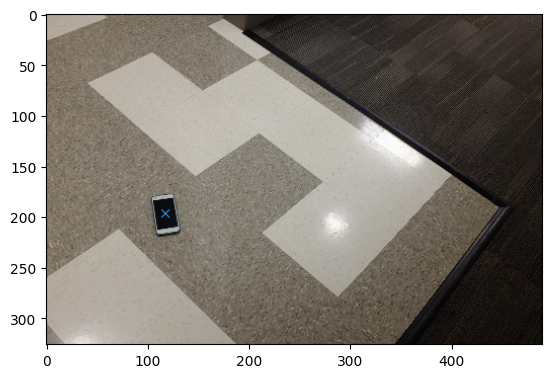

In [3]:
# Reading a sample image to check the dimensions
img = mpimg.imread('find_phone/51.jpg')
img = img/255.
plt.plot([490*0.2388],[326*0.6012],'x')
plt.imshow(img)

In [5]:
# Reading labels.txt file
metadata = []
with open("find_phone/labels.txt","r") as f:
    data = f.readline()
    while data:
        metadata.append(data.strip().split(" "))
        data = f.readline()

In [6]:
# Checking the shape of the image
img.shape

(326, 490, 3)

In [7]:
# Creating a dataset
x, x_gray, y = np.zeros((len(metadata),326,490,3)), np.zeros((len(metadata),326,490)), np.empty((len(metadata),2))
for i,data in enumerate(metadata):
    img = mpimg.imread('find_phone/'+data[0])
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.
    img_gray = img_gray/255.
    x[i,:,:,:] = img
    x_gray[i,:,:] = img_gray
    y[i,0], y[i,1] = np.float(data[1]), np.float(data[2])

/tmp/ipykernel_18052/3221055654.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y[i,0], y[i,1] = np.float(data[1]), np.float(data[2])


In [8]:
# Scaling y images, so that the points can be mapped on the image directly
y_scaled = y.copy()
y_scaled[:,0] = 490*y_scaled[:,0]
y_scaled[:,1] = 326*y_scaled[:,1]

1. Input images are loaded as normal 3 channel images and as gray scale images
2. Usuage of gray scale images:
    * Performing PCA would be easy and would be able to explain the data with less number of features.
3. To tackle the above problem, I've choosen 3 approaches:
    * Machine Learnig Approach: Used PCA along with SVM Regression
    * Deep Learning Approach : Used a simple Fully-Connected Dense layer architecture to check the performance.
    * Transfer Learning Approach : Because of limited resources I choose InceptionV3 network to use a pretrained model and train the model and evaluate the performance.

## 1. PCA with SVR

* Idea behind :
    * Since the images appear to be not complex, using PCA could be a better think as it can lower the dimension of the image.
    * With lower dimension it would be feasible to use Machine Learning Techniques to evaluate the performance.

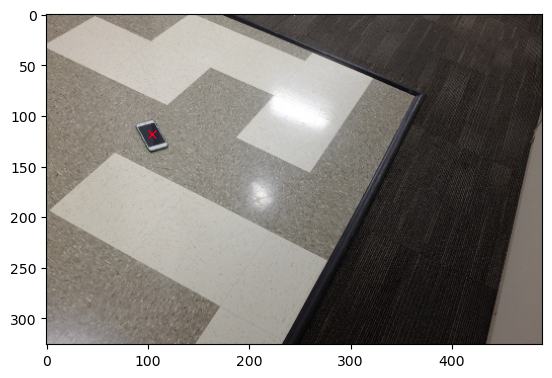

In [43]:
# Checking if the scaled and normal values align
idx = 100
plt.plot([490*y[idx,0]], [326*y[idx,1]],'bx')
plt.plot([y_scaled[idx,0]], [y_scaled[idx,1]],'rx')
plt.imshow(x[idx,:,:,:], cmap="gray")

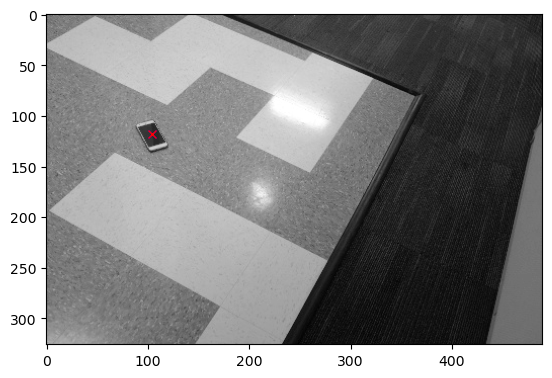

In [44]:
# Checking for gray scale image
idx = 100
plt.plot([490*y[idx,0]], [326*y[idx,1]],'bx')
plt.plot([y_scaled[idx,0]], [y_scaled[idx,1]],'rx')
plt.imshow(x_gray[idx,:,:], cmap="gray")

In [45]:
# Sanity check for evaluating if the points are coorectly loaded
y[idx,0],y[idx,1]

(0.2122, 0.362)

In [46]:
# Flatten the image for PCA into 2D
x_gray_flat = x_gray.reshape((len(metadata),-1))
x_flat = x.reshape((len(metadata),-1))
x_gray_flat.shape, x_flat.shape

((129, 159740), (129, 479220))

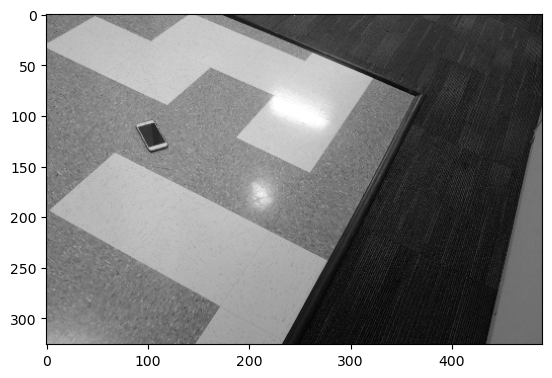

In [47]:
# Checking if the flattened image is rightly aligned
plt.imshow(x_gray_flat[idx].reshape(326,490), cmap="gray")

In [58]:
# PCA
pca = PCA(n_components=100, whiten=True)
x_trans = pca.fit_transform(x_gray_flat)
x_trans.shape

(129, 100)

In [59]:
# Reduces from (129, 479220) -> (129, 100) and explains 98% of data
pca.explained_variance_ratio_.sum()

0.9839265113544846

* Observation:
    * We ca see that with just 100 principal components we can explain almost ~98.4% of the data.
    * Now let's explore pca components and see if the images are good enough to the original images.

In [60]:
pca.components_.shape

(100, 159740)

In [65]:
idx=100
n_comps = 100
rec_img = np.zeros((326,490))
coeffs = x_trans[idx]

for i in range(n_comps):
    rec_img += coeffs[i]*pca.components_[i].reshape(326,490)


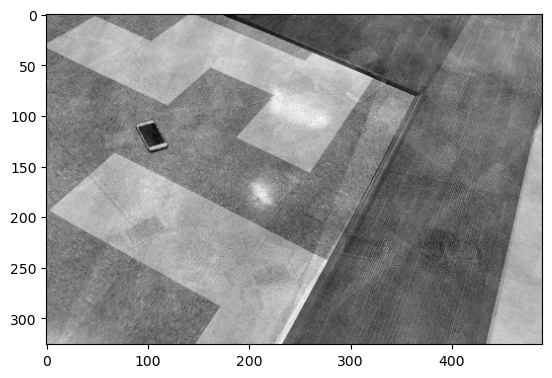

In [67]:
plt.imshow(rec_img, cmap="gray")

* Observation:
    * We can see that 100 components are able to regenerate the images.
    * Now let's split the data using custom `split_data` function with 70% train and 30% test data.

In [74]:
# Train test split
x_gray_train_pca, y_gray_train_pca, x_gray_test_pca, y_gray_test_pca = split_data(x_trans, y_scaled, test_frac=0.3)
x_gray_train_pca.shape, y_gray_test_pca.shape

((90, 100), (39, 2))

In [75]:
# Running SVM Regression, for 'x' coordinate with gray images
x_md = SVR()
x_md.fit(x_gray_train_pca, y_gray_train_pca[:,0])
y_pred_x = x_md.predict(x_gray_test_pca)
mse(y_gray_test_pca[:,0],y_pred_x)

14514.343002720909

In [76]:
# Running SVM Regression, for 'y' coordinate with gray images
y_md = SVR()
y_md.fit(x_gray_train_pca, y_gray_train_pca[:,1])
y_pred_y = y_md.predict(x_gray_test_pca)
mse(y_gray_test_pca[:,1]*326,y_pred_y)

3427324763.110736

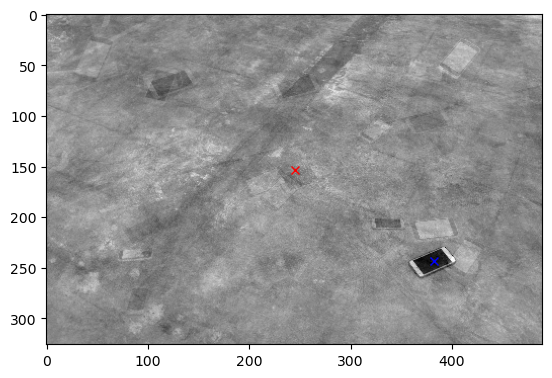

In [80]:
# Visualise on test
idx = 2
n_comps = 95
rec_img = np.zeros((326,490))
coeffs = x_gray_test_pca[idx]

for i in range(n_comps):
    rec_img += coeffs[i]*pca.components_[i].reshape(326,490)

plt.plot([y_pred_x[idx]], [y_pred_y[idx]],'rx',)
plt.plot([y_gray_test_pca[idx,0]], [y_gray_test_pca[idx,1]],'bx')
plt.imshow(rec_img, cmap="gray")

In [81]:
y_pred_x[idx], y_pred_y[idx], y_gray_test_pca[idx,0], y_gray_test_pca[idx,1]

(245.39915520765993,
 153.16522869769685,
 382.00399999999996,
 243.00039999999998)

In [82]:
# Visualise on train
y_pred_xtrain = x_md.predict(x_gray_train_pca)
mse(y_gray_train_pca[:,0],y_pred_xtrain)

12846.36281404467

In [84]:
y_pred_ytrain = y_md.predict(x_gray_train_pca)
mse(y_gray_train_pca[:,1],y_pred_ytrain)

5645.691933895104

* Observation
    * Since the training error(Mean Squared Error) for x,y are respectively (12846.36, 5645.7) and for testing set (14514.34,3427324763.11).
    * The training error is smaller as compared to testing set and this is a classical `overfitting example`
* Because of lack of time, let's explore deep learning solution.

## 2. FCN

* Since the number of images are small let's have a small architecture with less number of neurons.
* Let's use the PCA generated images and 3 channel raw images.

### 2.1 Using PCA data

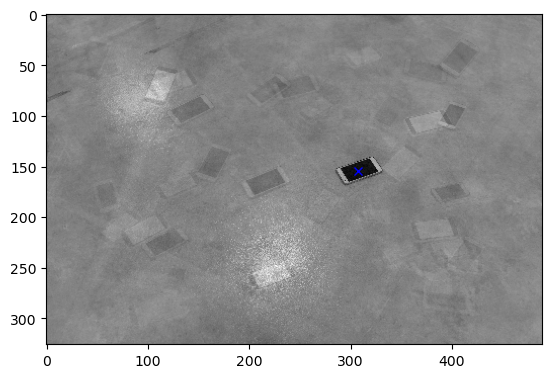

In [29]:
# Testing the train data
idx = 1
n_comps = 95
rec_img = np.zeros((326,490))
coeffs = x_train_pca[idx]

for i in range(n_comps):
    rec_img += coeffs[i]*pca.components_[i].reshape(326,490)

#plt.plot([y_pred_x[idx]], [y_pred_y[idx]],'rx',)
plt.plot([490*y_train_pca[idx,0]], [326*y_train_pca[idx,1]],'bx')
plt.imshow(rec_img, cmap="gray")

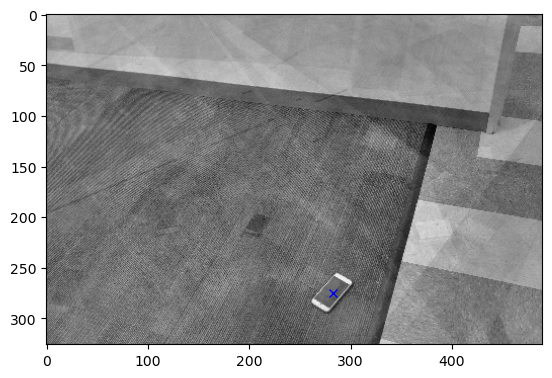

In [30]:
# Testing the test data
idx = 1
n_comps = 95
rec_img = np.zeros((326,490))
coeffs = x_test_pca[idx]

for i in range(n_comps):
    rec_img += coeffs[i]*pca.components_[i].reshape(326,490)

plt.plot([490*y_test_pca[idx,0]], [326*y_test_pca[idx,1]],'bx')
plt.imshow(rec_img, cmap="gray")

In [103]:
# Model Architecture
fc_model = build_model("FC",x_trans.shape)
fc_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 16)                1616      
                                                                 
 dense_16 (Dense)            (None, 32)                544       
                                                                 
 dense_17 (Dense)            (None, 2)                 66        
                                                                 
Total params: 2,226
Trainable params: 2,226
Non-trainable params: 0
_________________________________________________________________


In [104]:
# train the model
n_epochs=200
pca_history = fc_model.fit(x_trans,
                          y_scaled,
                          epochs=n_epochs,
                          validation_split=0.3,
                          verbose=True)

Epoch 1/200
1/3 [=========>....................] - ETA: 0s - loss: 62298.9609 - mse: 62298.9609

2023-03-02 18:50:19.179972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 81ms/step - loss: 55007.1914 - mse: 55007.1914 - val_loss: 44360.8203 - val_mse: 44360.8203
Epoch 2/200
3/3 [==============================] - 0s 20ms/step - loss: 54952.8828 - mse: 54952.8789 - val_loss: 44326.7812 - val_mse: 44326.7812
Epoch 3/200
3/3 [==============================] - 0s 19ms/step - loss: 54900.0000 - mse: 54900.0000 - val_loss: 44292.5469 - val_mse: 44292.5469
Epoch 4/200
1/3 [=========>....................] - ETA: 0s - loss: 52491.3984 - mse: 52491.3984

2023-03-02 18:50:19.392550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 20ms/step - loss: 54846.9883 - mse: 54846.9883 - val_loss: 44257.7891 - val_mse: 44257.7891
Epoch 5/200
3/3 [==============================] - 0s 18ms/step - loss: 54793.6797 - mse: 54793.6797 - val_loss: 44222.3984 - val_mse: 44222.3984
Epoch 6/200
3/3 [==============================] - 0s 18ms/step - loss: 54739.5586 - mse: 54739.5586 - val_loss: 44186.4375 - val_mse: 44186.4375
Epoch 7/200
3/3 [==============================] - 0s 19ms/step - loss: 54686.0234 - mse: 54686.0234 - val_loss: 44149.6875 - val_mse: 44149.6836
Epoch 8/200
3/3 [==============================] - 0s 18ms/step - loss: 54626.2227 - mse: 54626.2227 - val_loss: 44112.6602 - val_mse: 44112.6602
Epoch 9/200
3/3 [==============================] - 0s 18ms/step - loss: 54567.6445 - mse: 54567.6445 - val_loss: 44074.5508 - val_mse: 44074.5508
Epoch 10/200
3/3 [==============================] - 0s 18ms/step - loss: 54503.7773 - mse: 54503.7773 - val_loss: 44035.4688 - val_mse: 

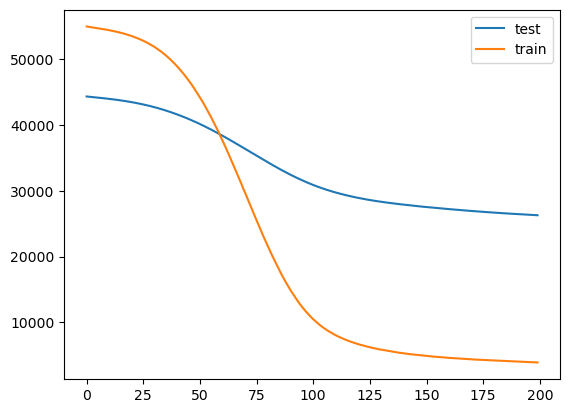

In [105]:
plt.plot(range(n_epochs),pca_history.history['val_mse'], label="test")
plt.plot(range(n_epochs),pca_history.history['mse'], label="train")
plt.legend()

* From the above Epoch vs Loss function, the model is again `Overfitting` and this was expected as we have less number of images.

In [106]:
y_pred = fc_model.predict(x_trans)

5/5 [==============================] - 0s 8ms/step


2023-03-02 18:51:00.310898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [107]:
y_pred.shape

(129, 2)

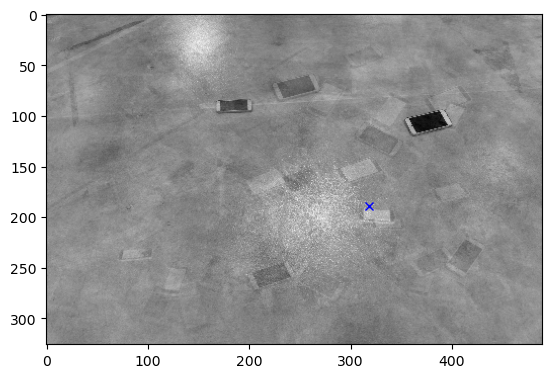

In [113]:
# Testing the test data
idx = 4
n_comps = n_comps
rec_img = np.zeros((326,490))
coeffs = x_trans[idx]

for i in range(n_comps):
    rec_img += coeffs[i]*pca.components_[i].reshape(326,490)

plt.plot([y_pred[idx,0]], [y_pred[idx,1]],'bx')
plt.imshow(rec_img, cmap="gray")

### 2.2) Using Raw Image

* Now, let's explore how the model would perform with more number of features by using raw images.
* The model was clearly overfitting with more number of parameters, hence decided to minimize the number of neurons to reduce avoid overfitting.

In [123]:
fc_model_raw = build_model("FC",x_flat.shape)
fc_model_raw.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 8)                 3833768   
                                                                 
 dense_22 (Dense)            (None, 8)                 72        
                                                                 
 dense_23 (Dense)            (None, 2)                 18        
                                                                 
Total params: 3,833,858
Trainable params: 3,833,858
Non-trainable params: 0
_________________________________________________________________


In [124]:
# train the model
n_epochs=75
raw_history = fc_model_raw.fit(x_flat,
                          y_scaled,
                          epochs=n_epochs,
                          validation_split=0.3,
                          verbose=True)

Epoch 1/75


2023-03-02 18:55:34.626345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 212ms/step - loss: 28452.7031 - mse: 28452.7031 - val_loss: 35709.8203 - val_mse: 35709.8203
Epoch 2/75
1/3 [=========>....................] - ETA: 0s - loss: 32117.2266 - mse: 32117.2266

2023-03-02 18:55:35.222682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 85ms/step - loss: 28381.4316 - mse: 28381.4316 - val_loss: 9534.0625 - val_mse: 9534.0625
Epoch 3/75
3/3 [==============================] - 0s 86ms/step - loss: 13282.0117 - mse: 13282.0117 - val_loss: 15929.0645 - val_mse: 15929.0645
Epoch 4/75
3/3 [==============================] - 0s 79ms/step - loss: 18913.8672 - mse: 18913.8672 - val_loss: 9376.8525 - val_mse: 9376.8525
Epoch 5/75
3/3 [==============================] - 0s 76ms/step - loss: 11725.2295 - mse: 11725.2285 - val_loss: 14188.5518 - val_mse: 14188.5518
Epoch 6/75
3/3 [==============================] - 0s 77ms/step - loss: 15493.0283 - mse: 15493.0283 - val_loss: 12799.1982 - val_mse: 12799.1973
Epoch 7/75
3/3 [==============================] - 0s 76ms/step - loss: 12460.3574 - mse: 12460.3574 - val_loss: 9236.6553 - val_mse: 9236.6553
Epoch 8/75
3/3 [==============================] - 0s 76ms/step - loss: 12886.5166 - mse: 12886.5166 - val_loss: 10088.0078 - val_mse: 10088.0078
Ep

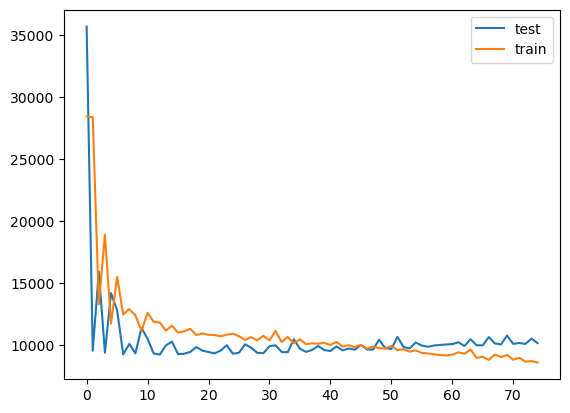

In [125]:
plt.plot(range(n_epochs),raw_history.history['val_mse'], label="test")
plt.plot(range(n_epochs),raw_history.history['mse'], label="train")
plt.legend()

* We can see from the above plot that the model starts to overfit after ~45 epochs.
* Because of lack of time let's perform `Transfer Learning`.

In [126]:
y_pred = fc_model_raw.predict(x_flat)

5/5 [==============================] - 0s 18ms/step


2023-03-02 18:56:18.575030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


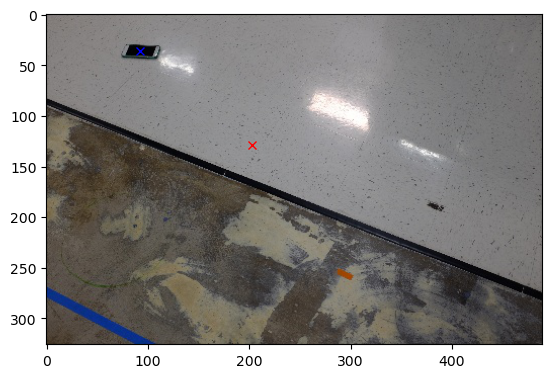

In [127]:
idx = 10
plt.plot([y_scaled[idx,0]], [y_scaled[idx,1]],'bx')
plt.plot([y_pred[idx,0]], [y_pred[idx,1]],'rx')
plt.imshow(x_flat[idx].reshape(326,490,3), cmap="gray")

## 3. Transfer Learning

* Since inceptionV3 is a deep network, let's use raw images.

### 3.1) InceptionV3

In [9]:
inception = tf.keras.applications.InceptionV3(weights='imagenet',include_top=False, 
                                              input_shape=x.shape[1:])

2023-03-03 11:17:50.092084: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-03 11:17:51.170739: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15532 MB memory:  -> device: 0, name: Quadro P5000, pci bus id: 0000:17:00.0, compute capability: 6.1
2023-03-03 11:17:51.171580: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 15532 MB memory:  -> device: 1, name: Quadro P5000, pci bus id: 0000:65:00.0, compute capability: 6.1


In [10]:
inception.trainable = True
last_layer = inception.get_layer('mixed10')
layer_output = last_layer.output
layer_output

<KerasTensor: shape=(None, 8, 13, 2048) dtype=float32 (created by layer 'mixed10')>

In [11]:
# Dense model architecture
x1 = layers.Flatten()(layer_output)
x1 = layers.Dropout(0.3)(x1)
x1 = layers.Dense(4112, activation="relu")(x1)
x1 = layers.Dense(1028, activation="relu")(x1)
x1 = layers.Dense(1028, activation="relu")(x1)
x1 = layers.Dropout(0.5)(x1)
x1 = layers.Dense(256, activation="relu")(x1)
coordinates = layers.Dense(2, name="coordinates")(x1)

model = tf.keras.Model(inputs=inception.inputs, outputs=coordinates)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 326, 490, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 162, 244, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 162, 244, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [13]:
# Applying learning rate decay after say 40 epochs
def scheduler(epoch, lr):
    if epoch<40:
        return lr
    else:
        return lr*tf.math.exp(-0.12)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [14]:
# Complining the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
             loss = {'coordinates':'mse'},
             metrics={'coordinates':'mse'})

In [18]:
# Split the data into training and testing
x_train, y_train, x_test, y_test = split_data(x, y_scaled, test_frac=0.3)
x_train.shape, x_test.shape

((90, 326, 490, 3), (39, 326, 490, 3))

In [19]:
# Saving the best model
save_path = "models/{epoch:02d}-{val_mse:.2f}.h5"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = save_path,
                                                 save_weights_only=True,
                                                 monitor='val_mse',
                                                 mode='min',
                                                 save_best_only=True)

In [20]:
# Train the model
n_epochs = 70
hist = model.fit(x_train, y_train,
                epochs=n_epochs,
                batch_size=8,
                validation_data=(x_test,y_test),
                callbacks=[callback, cp_callback])

Epoch 1/70


2023-03-03 11:18:25.531747: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8800


12/12 [==============================] - 22s 992ms/step - loss: 22331.0664 - mse: 22331.0664 - val_loss: 10356.8164 - val_mse: 10356.8164 - lr: 1.0000e-04
Epoch 2/70
12/12 [==============================] - 8s 705ms/step - loss: 8725.8340 - mse: 8725.8340 - val_loss: 6232.2012 - val_mse: 6232.2012 - lr: 1.0000e-04
Epoch 3/70
12/12 [==============================] - 8s 710ms/step - loss: 4601.4702 - mse: 4601.4702 - val_loss: 4932.1919 - val_mse: 4932.1919 - lr: 1.0000e-04
Epoch 4/70
12/12 [==============================] - 8s 711ms/step - loss: 4051.7756 - mse: 4051.7756 - val_loss: 4037.1499 - val_mse: 4037.1499 - lr: 1.0000e-04
Epoch 5/70
12/12 [==============================] - 8s 714ms/step - loss: 3342.3652 - mse: 3342.3652 - val_loss: 2936.8635 - val_mse: 2936.8635 - lr: 1.0000e-04
Epoch 6/70
12/12 [==============================] - 12s 1s/step - loss: 2372.6001 - mse: 2372.6001 - val_loss: 2683.7688 - val_mse: 2683.7688 - lr: 1.0000e-04
Epoch 7/70
12/12 [========================

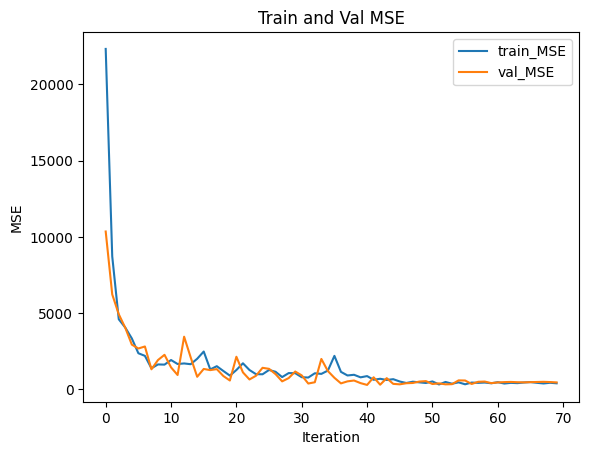

In [53]:
# Plotting the losses
train_mse, val_mse = hist.history['mse'], hist.history['val_mse']

plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.plot(range(n_epochs), train_mse, label="train_MSE")
plt.plot(range(n_epochs), val_mse, label="val_MSE")
plt.title("Train and Val MSE")
plt.legend()

### 3.2) Loading the best Model

In [26]:
# loading the best model
model.load_weights('models/41-295.03.h5')

In [46]:
y_pred_val, y_pred_train = model.predict(x_test), model.predict(x_train)
y_pred_val.shape, y_pred_train.shape

3/3 [==============================] - 1s 702ms/step


((39, 2), (90, 2))

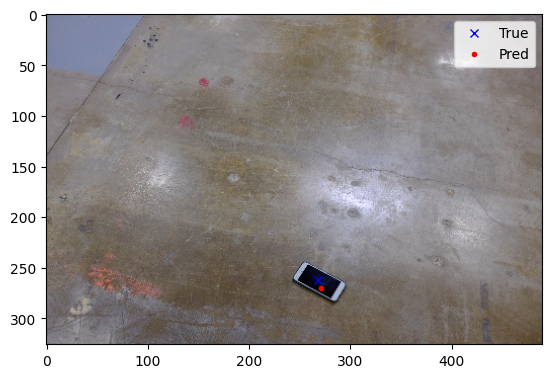

In [47]:
# Plotting the predictions on val set
idx = 34
plot_imgs(x_test,y_test, y_pred_val, idx)

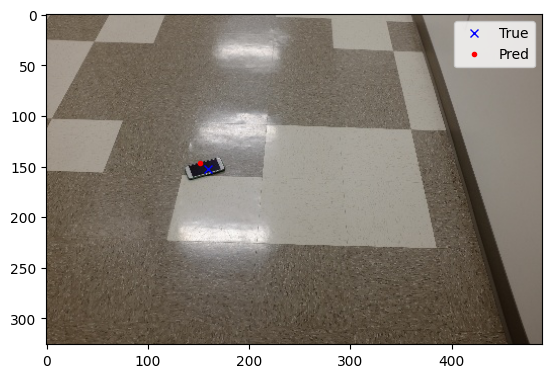

In [52]:
# Plotting the predictions on train set
idx = 50
plot_imgs(x_train, y_train, y_pred_train, idx)

* Observation
    * Choosen model has a Validation MSE of ~295, and is the best performance so far.
    * We can see from the above predictions that the model is performing well on the validation as well training set.

## Utility Function

### Supporting functions

In [16]:
def split_data(x,y,test_frac=0.3):
    n = x.shape[0]
    shuffle_idx = np.random.permutation(range(n))
    idx = int(n*(1-test_frac))
    train_idx, test_idx = shuffle_idx[:idx], shuffle_idx[idx:]
    
    return x[train_idx],y[train_idx],x[test_idx],y[test_idx]

In [17]:
# Type could be "FC"
def build_model(type,input_shape):
    if type=="FC":
        model = tf.keras.Sequential([
            layers.Dense(8,activation='relu',input_shape=[input_shape[1]]),
            layers.Dense(8,activation='relu'),
#             layers.Dropout(0.25),
#             layers.Dense(64,activation='relu'),
            layers.Dense(2)
        ])
        
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss="mse",
                         optimizer=optimizer,
                          metrics=['mse']
                         )
        
    return model

In [33]:
def plot_imgs(imgs,y_true, y_pred,idx=1):
    plt.plot(y_true[idx,0], y_true[idx,1],'bx', label="True")
    plt.plot(y_pred[idx,0], y_pred[idx,1],'r.', label="Pred")
    plt.legend()
    plt.imshow(imgs[idx])
    plt.show()